# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Strata](#Strata)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Metaclassifier](#Metaclassifier)
* [Results](#Results)
  * [Classifier prediction correlations](#Classifier-prediction-correlations)
* [Discussion](#Discussion)

# Introduction

In this notebook, the tree-based methods from previous explorations are more closely examined. Tree-based models have been less performant, so examining them more closely may yield candidates for omission from continued consideration. On the contrary, the ensembles appeared to degrade performance.

A test harness is prepared for multinomial ternary classification on FRILL embeddings. The results are visualized and discussed.

## FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from itertools import combinations
from tqdm.notebook import tqdm

# typing
from sklearn.base import BaseEstimator
from typing import Dict, List, Sequence

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score

# scale & resample
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import OneSidedSelection

# cross validator
from sklearn.model_selection import StratifiedGroupKFold

# sklearn classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# other boosting classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 5.17 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 117 ms


# Data loading

In [5]:
keep_columns = [
    "id",
    "source",
    "speaker_id",
    "speaker_gender",
    "emo",
    "valence",
    "lang1",
    "length",
]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")

time: 358 ms


In [6]:
# uncomment lines to undersample data
# data = data.sample(frac=0.05, random_state=SEED).sort_index()  # .head(200)
# labels = labels.loc[data.index, :]  # .head(200)

assert all(data.index == labels.index)
_ = gc_collect()

time: 128 ms


In [7]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 138.4 MB


,source,speaker_id,speaker_gender,emo,valence,lang1,length
id,,,,,,,
0,aesdd,aesdd.1,f,ang,0,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          17703 non-null  category
 1   speaker_id      17703 non-null  category
 2   speaker_gender  17703 non-null  category
 3   emo             17703 non-null  category
 4   valence         17703 non-null  int8    
 5   lang1           17703 non-null  category
 6   length          17703 non-null  category
dtypes: category(6), int8(1)
memory usage: 321.6 KB
time: 163 ms


# Strata

In this section, strata are set up for the train-test split.

In [8]:
N_SPLITS = 5

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 17703/17703 [00:00<00:00, 83968.99it/s]

time: 265 ms


In [9]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 130 ms


In [10]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
del strata
STRATA.value_counts()

merge passes performed: 0
only 1: 28
only 2: 19
only 3: 10
only 4: 5
merge passes performed: 1
only 1: 23
only 2: 9
only 3: 0
only 4: 0
merge passes performed: 2
only 1: 14
only 2: 0
only 3: 9
only 4: 0
merge passes performed: 3
only 1: 5
only 2: 0
only 3: 0
only 4: 9
merge passes performed: 4
only 1: 0
only 2: 0
only 3: 0
only 4: 4
merge passes performed: 5
only 1: 0
only 2: 0
only 3: 0
only 4: 0


esdfsur0cmnmedium               984
esdfang0cmnmedium               982
esdfsad0cmnmedium               736
esdmhap2cmnmedium               689
esdfhap2cmnmedium               688
                               ... 
EmoReact_V_1.0fneu1engmedium      5
BAUM1fsad0turlong                 5
stratum_group_14                  5
stratum_group_10                  5
stratum_group_11                  5
Length: 168, dtype: int64

time: 340 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [11]:
METRICS = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_geometric_mean",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's score and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 168 ms


In [12]:
predictions_ = {key: [] for key in {"model", "case", "fold", "y_pred", "split"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 152 ms


The cross-validation splits are pre-computed to save time in the main loops.

In [13]:
CV_info = namedtuple(
    "CV_info",
    _ := "X_train X_test y_train y_test",
    defaults=[None] * len(_.split()),
)
assert all(data.index == STRATA.index)
assert all(STRATA.index == labels.index)
prepared_splits = [
    *StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED).split(
        X=data, y=STRATA, groups=labels.speaker_id
    )
]

scaler = lambda: MinMaxScaler(feature_range=(-1, 1))  # preserve sign
make_adasyn = lambda strategy: ADASYN(
    sampling_strategy=strategy, random_state=SEED, n_jobs=-1
).fit_resample


def get_splits(case: str, resampled: bool = True) -> List[CV_info]:
    """Prepares the three-fold cross-validation splits ternary classification."""
    splits = []
    for train_idx, test_idx in prepared_splits:
        # select and scale
        scale = scaler().fit(X_train := data.iloc[train_idx])
        X_train = scale.transform(X_train)
        X_test = scale.transform(data.iloc[test_idx])
        y_train = labels.valence.iloc[train_idx]
        y_test = labels.valence.iloc[test_idx]

        if resampled:
            # oversample with adasyn, undersample with oss
            train = make_adasyn("not majority")(X_train, y_train)
            try:
                train = make_adasyn("not majority")(X_train, y_train)
            except ValueError:
                try:
                    train = make_adasyn("not minority")(X_train, y_train)
                except ValueError:
                    try:
                        train = make_adasyn("all")(X_train, y_train)
                    except ValueError:
                        train = make_adasyn("not minority")(X_train, y_train)
            X_train, y_train = OneSidedSelection(
                random_state=SEED, n_jobs=-1
            ).fit_resample(*train)

        # reset indices
        splits.append(
            CV_info(
                X_train=X_train,
                y_train=y_train.reset_index(drop=True),
                X_test=X_test,
                y_test=y_test.reset_index(drop=True),
            )
        )
    return splits


DATA_CHOOSER: Dict[str, List[CV_info]] = {case: get_splits(case) for case in ALL_CASES}

del scaler
_ = gc_collect()

time: 2min 43s


# Models

Thanks to FRILL, we may now use the gamut of classifiers provided by `sklearn`. Boosting methods outside of `sklearn` include `LightGBM` and `XGBoost`. We also consider ensembles of these classifiers.

Because XGBoostClassifier takes a long time to train, we will train a LogisticRegression estimator in lieu of sklearn's StackingClassifier, which uses LogisticRegression as the metaestimator by default.

In previous explorations, XGBoost has usually been the most performant tree-based classifier. To constrain the number of stacked ensembles to evaluate, we therefore only consider stacks that contain XGBoost, each model individually, and the stack containing all models except for XGBoost; this works out to 12 first-order estimators to consider (plus one dummy).

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Class weight parameters are set to address class imbalance. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [14]:
MODELS = {
    "AdaBoost": lambda: AdaBoostClassifier(random_state=SEED),
    "LGBM": lambda: LGBMClassifier(
        class_weight="balanced", random_state=SEED, n_jobs=-1
    ),
    "RandomForest": lambda: RandomForestClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ),
    "XGB": lambda: XGBClassifier(
        tree_method="gpu_hist",
        n_jobs=-1,
        random_state=SEED,
        validate_parameters=True,
        eval_metric="mlogloss",
        use_label_encoder=False,
        single_precision_histogram=True,
    ),
    "Dummy": lambda: DummyClassifier(random_state=SEED),
}


def make_stack(X_train: pd.DataFrame, y_train: Sequence) -> BaseEstimator:
    """Trains a logistic regression on input data."""
    return LogisticRegression(
        class_weight="balanced", random_state=SEED, n_jobs=-1
    ).fit(X_train, y_train)


_ = gc_collect()

time: 153 ms


# Test harness

This section defines functions for evaluating models.

In [15]:
def evaluate_model(
    model_base: str, case: str, resample: bool = False, track_fold_time: bool = False
) -> AvgScores:
    """Evaluate a binary classification model with three-fold stratified grouped cross validation."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean = [], [], [], [], []
    selected_data: List[CV_info] = DATA_CHOOSER[case]
    for fold_num in range(N_SPLITS):
        if track_fold_time:
            fold_begin = time()

        # obtain prepared folds
        fold_data: CV_info = selected_data[fold_num]

        # define train
        X_train = fold_data.X_train
        y_train = fold_data.y_train

        # define test
        X_test = fold_data.X_test
        y_test = fold_data.y_test

        # initialize binary model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # store train prediction for metaclassifier training
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=model.predict(X_train),
                split="train",
            ),
        )

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        print(f"predicted in {end - begin:.2f} s")

        # store prediction results
        predict_times.append(end - begin)
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=predicted,
                split="test",
            ),
        )

        # score
        score_params = {"y_true": y_test, "y_pred": predicted}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )

        # free some memory
        del begin
        del end
        del model
        del predicted
        del score_params
        del X_test
        del X_train
        del y_test
        del y_train
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (balanced_accuracy, f1, geometric_mean, fit_times, predict_times)
        ]
    )


_ = gc_collect()

time: 160 ms


The next cell evaluates models.

In [16]:
case = "ternary"
for model in tqdm(MODELS):
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case, track_fold_time=True),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    _ = gc_collect()

  0%|          | 0/5 [00:00<?, ?it/s]

evaluating AdaBoost...
fitted in 377.90 s
predicted in 0.17 s
AdaBoost fold 1 completed in 378.93 s
fitted in 337.52 s
predicted in 0.14 s
AdaBoost fold 2 completed in 338.47 s
fitted in 329.99 s
predicted in 0.16 s
AdaBoost fold 3 completed in 330.94 s
fitted in 320.76 s
predicted in 0.18 s
AdaBoost fold 4 completed in 321.71 s
fitted in 335.43 s
predicted in 0.17 s
AdaBoost fold 5 completed in 336.34 s
stored AdaBoost for ternary classification in 1707.01 s
evaluating LGBM...
fitted in 68.43 s
predicted in 0.14 s
LGBM fold 1 completed in 68.96 s
fitted in 61.77 s
predicted in 0.14 s
LGBM fold 2 completed in 62.23 s
fitted in 61.45 s
predicted in 0.13 s
LGBM fold 3 completed in 61.90 s
fitted in 59.58 s
predicted in 0.16 s
LGBM fold 4 completed in 60.07 s
fitted in 68.06 s
predicted in 0.21 s
LGBM fold 5 completed in 68.63 s
stored LGBM for ternary classification in 322.61 s
evaluating RandomForest...
fitted in 12.30 s
predicted in 0.08 s
RandomForest fold 1 completed in 12.71 s
fitte

Let's peek at the results.

In [17]:
results_df = (
    pd.DataFrame(results_).sort_values(by=["model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_balanced_accuracy,avg_cv_geometric_mean,avg_cv_f1,case,model_name,avg_cv_predict_time,avg_cv_fit_time
0,0.481518,0.473221,0.488883,ternary,AdaBoost,0.165158,340.320800
1,0.333333,0.000000,0.204143,ternary,Dummy,0.000000,0.004855
2,0.541516,0.504539,0.584568,ternary,LGBM,0.155456,63.857379
3,0.452871,0.380705,0.517582,ternary,RandomForest,0.100593,13.079502
4,0.528232,0.484352,0.582361,ternary,XGB,0.117445,96.735002


time: 20 ms


# Metaclassifier

After the binary classifiers are evaluated, the metaclassifiers are evaluated based on the binary predictions. The metaclassifiers' fit and score times are estimated by summing the fit and score times of the base estimators.

In [18]:
case = "ternary"
fold_cv_info: List[pd.Series] = [
    DATA_CHOOSER[case][fold] for fold in range(N_SPLITS)
]  # list indexed by fold

predictions_df = pd.DataFrame(predictions_).query(f"case == '{case}'")
results_df = pd.DataFrame(results_).query(f"case == '{case}'")[
    ["model_name", "avg_cv_fit_time", "avg_cv_predict_time"]
]

fitted_stacks, stack_scores = {}, {}
blank_scores = lambda: AvgScores(**{field: [] for field in AvgScores._fields})
# obtain scores and predictions per fold
for fold_num in range(N_SPLITS):

    # select y_train and y_test
    selected_ys = fold_cv_info[fold_num]
    y_train, y_test = selected_ys.y_train, selected_ys.y_test
    del selected_ys

    # obtain fold predictions
    fold_pred_df = predictions_df.query(f"fold == {fold_num}")
    fold_query_model_pred = lambda model, split: fold_pred_df.query(
        f"model == '{model}' & split == '{split}'"
    ).y_pred.item()
    fold_prediction_dfs = {
        split: pd.DataFrame(
            {model: fold_query_model_pred(model, split) for model in MODELS}
        ).drop("Dummy", axis="columns")
        for split in {"train", "test"}
    }

    # "fit"
    train_df = fold_prediction_dfs["train"]
    for non_xgb_col in train_df.drop(
        "XGB", axis="columns"
    ).columns:  # stacks with 2 models
        fitted_stacks[f"XGB+{non_xgb_col}"] = make_stack(
            train_df[["XGB", non_xgb_col]], y_train
        )
    for triple in combinations(train_df.columns, 3):  # stacks with 3 models
        fitted_stacks["+".join(triple)] = make_stack(train_df[list(triple)], y_train)
    # stack with 4 models
    fitted_stacks["+".join(train_df.columns)] = make_stack(train_df, y_train)
    del train_df

    # "predict"
    test_df = fold_prediction_dfs["test"]
    for stack_name, fitted_stack in fitted_stacks.items():
        y_pred = fitted_stack.predict(test_df[stack_name.split("+")])
        # record y_pred
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=stack_name,
                case="ternary",
                fold=fold_num,
                y_pred=y_pred,
                split="test",
            ),
        )
        # score
        score_params = {
            "y_true": y_test,
            "y_pred": y_pred,
        }
        score_store = blank_scores()
        score_store.avg_cv_balanced_accuracy.append(
            balanced_accuracy_score(**score_params)
        )
        score_store.avg_cv_f1.append(f1_score(**score_params, average="weighted"))
        score_store.avg_cv_geometric_mean.append(geometric_mean_score(**score_params))
        stack_scores[stack_name] = score_store
        del score_params
        del score_store
        _ = gc_collect()
    del test_df
    _ = gc_collect()

# store results
for stack_name, avg_scores in stack_scores.items():
    _df = results_df.loc[results_df.model_name.isin(stack_name.split("+"))]
    sum_times = lambda time_metric: _df[time_metric].sum()
    store_result(
        where=results_,
        case="ternary",
        model_name=stack_name,
        avg_scores=AvgScores(
            np.mean(avg_scores.avg_cv_balanced_accuracy),
            np.mean(avg_scores.avg_cv_f1),
            np.mean(avg_scores.avg_cv_geometric_mean),
            sum_times("avg_cv_fit_time"),
            sum_times("avg_cv_predict_time"),
        ),
    )
    del _df
    del sum_times
    _ = gc_collect()

# re-define predictions_df and results_df since predictions_ and results_ have been modified
predictions_df = pd.DataFrame(predictions_)
results_df = pd.DataFrame(results_)

time: 16.7 s


Let's peek at the results.

In [19]:
results_df = (
    pd.DataFrame(results_).sort_values(by=["model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_balanced_accuracy,avg_cv_geometric_mean,avg_cv_f1,case,model_name,avg_cv_predict_time,avg_cv_fit_time
0,0.481518,0.473221,0.488883,ternary,AdaBoost,0.165158,340.320800
1,0.405531,0.304986,0.428443,ternary,AdaBoost+LGBM+RandomForest,0.421207,417.257681
2,0.447811,0.348130,0.463902,ternary,AdaBoost+LGBM+RandomForest+XGB,0.538652,513.992684
3,0.480370,0.414800,0.512817,ternary,AdaBoost+LGBM+XGB,0.438059,500.913182
4,0.450083,0.350779,0.465562,ternary,AdaBoost+RandomForest+XGB,0.383196,450.135304
5,0.333333,0.000000,0.204143,ternary,Dummy,0.000000,0.004855
6,0.541516,0.504539,0.584568,ternary,LGBM,0.155456,63.857379
7,0.447811,0.348130,0.463902,ternary,LGBM+RandomForest+XGB,0.373494,173.671884
8,0.452871,0.380705,0.517582,ternary,RandomForest,0.100593,13.079502
9,0.528232,0.484352,0.582361,ternary,XGB,0.117445,96.735002


time: 20 ms


# Results

In this section, we create several visualizations to display the results.

In [20]:
METRIC_NAMES = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_geometric_mean": "geometric mean",
    "avg_cv_predict_time": "predict time",
}

_ = gc_collect()

time: 116 ms


In [21]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy+dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[~results_df.model_name.str.contains("Dummy")]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(8)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    plt.setp(ax.patches, linewidth=0)
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", x=0.15)
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 117 ms


  0%|          | 0/5 [00:00<?, ?it/s]

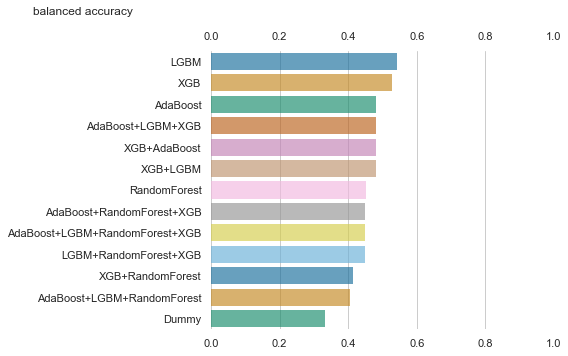

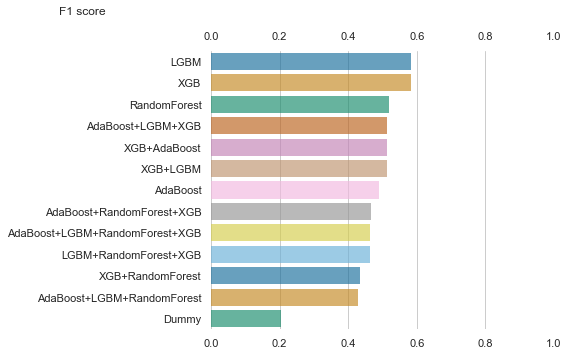

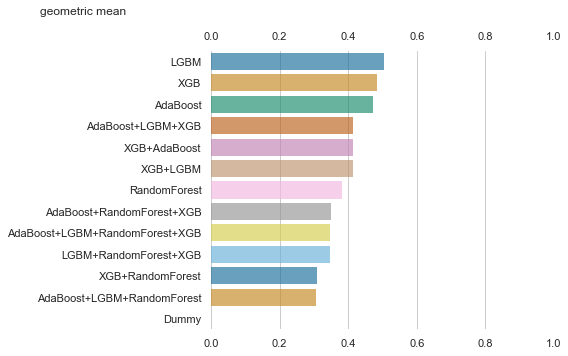

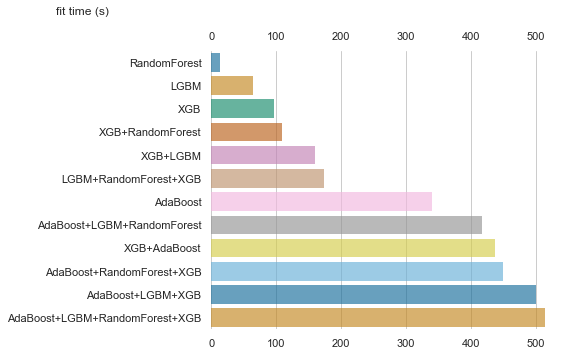

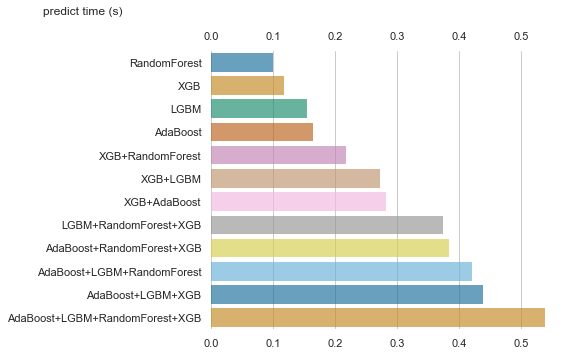

time: 2.19 s


In [22]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df)

## Classifier prediction correlation

In this section, we assess the correlation between each model's predictions. Performant and uncorrelated models are ideal for a potential stacked classifier.

For each case, pairwise Pearson correlations are calculated between model predictions and the absolute values of the correlation coefficients averaged over the folds. This is not a statistically pure approach since better methods for assessing categorical correlations (e.g., Cramer's V or Theil's U) exist and the Fisher's Z transformation was omitted, but it should be good enough; we just need to assess co-occurence to see which are most unassociated.

In [23]:
fold_correlations = []
for fold in range(N_SPLITS):
    df = predictions_df.query(f"fold == {fold} & split == 'test'")
    df = (
        pd.DataFrame(
            {model: df.loc[df.model == model, "y_pred"].item() for model in MODELS}
        )
        .corr()
        .swifter.apply(abs)
    )
    fold_correlations.append(df)
    del df
    _ = gc_collect()
prediction_correlations = (_ := pd.concat(fold_correlations)).groupby(_.index).mean()

del fold_correlations
_ = gc_collect()

Pandas Apply: 100%|██████████| 5/5 [00:00<?, ?it/s]


time: 898 ms


<Figure size 576x576 with 0 Axes>

Text(0.5, 0.98, 'prediction correlations of base estimators')

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'AdaBoost'),
  Text(0, 1.5, 'LGBM'),
  Text(0, 2.5, 'RandomForest'),
  Text(0, 3.5, 'XGB')])

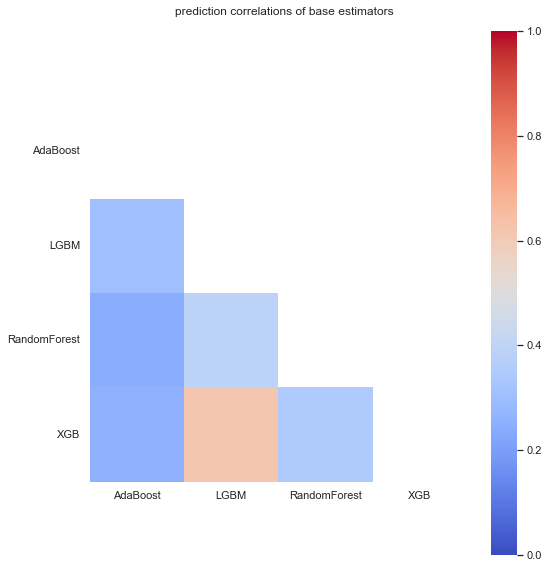

time: 394 ms


In [24]:
# plot heatmap for prediction correlations
plt.figure(figsize=(8, 8))
df = prediction_correlations.dropna(axis="columns", how="all").dropna(
    axis="index", how="all"
)
g = sns.heatmap(
    data=df,
    vmin=0,
    vmax=1,
    cmap="coolwarm",
    square=True,
    mask=np.triu(np.ones_like(df, dtype=bool)),
)
plt.suptitle(f"prediction correlations of base estimators")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

del df
del g
_ = gc_collect()

In [25]:
# save table of results
results_df.to_csv(
    f"{DATA_OUT_FOLDER}/explore_tree-based_models_results_CV{N_SPLITS}.csv"
)

time: 8.97 ms


# Discussion

LGBM appears to be the most skilled of the tree methods considered. It is also the second fastest.

Ensembling with LogisticRegression did not improve performance. In fact, ensembling appeared to degrade performance.

I am happy to remove all tree-based classifiers but LGBM from further consideration.

In [26]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 2786.2545278072357 s
time: 115 ms


[^top](#Contents)